# Fake News Detection

**Author**: Marcelo Scatena
***
March 2022

# Google nnlm-en-dim128

Googles nnlm-en-dim128 is a pre-trained text embedding module. We can access it via Tensorflow Hub, which is a library containing hundreds of machine learning models. The specific model I'll be using has 128 dimensions and have been trained in the English Google News 200B corpus. The module can be found [here](https://tfhub.dev/google/nnlm-en-dim128/2) and the extended text embedding library can found [here](https://tfhub.dev/s?module-type=text-embedding).<br />
As with other embeding techniques, little preprocessing is needed, so the cleaning stage of the data is smaller than with categorical encoding.

In [5]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.corpus import stopwords

import string
import re

from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras import regularizers
from sklearn.preprocessing import LabelEncoder

import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

In [6]:
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
raw_train = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
raw_test = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
raw_val = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

In [7]:
train_df = raw_train.copy()
val_df = raw_val.copy()
test_df = raw_test.copy()

In [8]:
def drop_na(df):
    df = df.dropna(subset=['statement'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df

def label(df):
    df['label'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df

def drop_features(df):
    df = df[['statement','label']]
    return df

def reset_index(df):
    df['statement'] = df['statement'].apply(lambda x: x.lower())
    return df

def remove_punctuation(df):
    df['statement'] = df['statement'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))
    return df

def lower_case(df):
    df = df.reset_index(drop=True)
    return df

In [9]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('drop_features', FunctionTransformer(drop_features)),
    ('reset_index', FunctionTransformer(reset_index)),
    ('remove_punctuation', FunctionTransformer(remove_punctuation)),
    ('lower_case', FunctionTransformer(lower_case))
])

In [10]:
train_df.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [11]:
df_train_clean = cleaning_pipeline.fit_transform(train_df)
df_val_clean = cleaning_pipeline.transform(val_df)
df_test_clean = cleaning_pipeline.transform(test_df)

In [12]:
df_train_clean.head()

,statement,label
0,says the annies list political group supports ...,0
1,when did the decline of coal start it started ...,1
2,hillary clinton agrees with john mccain by vot...,1
3,health care reform legislation is likely to ma...,0
4,the economic turnaround started at the end of ...,1


In [13]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df_train_clean['statement'])
num_unique_words = len(counter)

In [14]:
num_unique_words

13453

In [15]:
# Fit my tokenizer with train data
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(df_train_clean['statement'])

In [16]:
# Here I set my maximum sentence length and resize sentences to it
max_length = 15
vocab_size = num_unique_words

sequences_train = tokenizer.texts_to_sequences(df_train_clean['statement'])
sequences_val = tokenizer.texts_to_sequences(df_val_clean['statement'])
sequences_test = tokenizer.texts_to_sequences(df_test_clean['statement'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
padded_val = pad_sequences(sequences_val, padding = 'post', maxlen=max_length)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

In [17]:
# Statement tokenized
sequences_train[0]

[7, 1, 7130, 1112, 508, 596, 364, 5155, 558, 11, 1564]

In [18]:
# Statement tokenized and padded
padded_train[0]

array([   7,    1, 7130, 1112,  508,  596,  364, 5155,  558,   11, 1564,
          0,    0,    0,    0])

In [19]:
y_train = df_train_clean['label']
y_val = df_val_clean['label']
y_test = df_test_clean['label']

In [21]:
padded_train.shape, y_train.shape, padded_val.shape, y_val.shape, padded_test.shape, y_test.shape

((10240, 15), (10240,), (1284, 15), (1284,), (1267, 15), (1267,))

In [22]:
X_train_clean = df_train_clean['statement']
X_val_clean = df_val_clean['statement']
X_test_clean = df_test_clean['statement']

In [23]:
X_train_clean[:2]

0    says the annies list political group supports ...
1    when did the decline of coal start it started ...
Name: statement, dtype: object

In [24]:
# Transform Series data into Numpy array
X_train_clean_arr = np.asarray(X_train_clean)
X_val_clean_arr = np.asarray(X_val_clean)
X_test_clean_arr = np.asarray(X_test_clean)

In [25]:
X_train_clean_arr[:2]

array(['says the annies list political group supports thirdtrimester abortions on demand',
       'when did the decline of coal start it started when natural gas took off that started to begin in president george w bushs administration'],
      dtype=object)

In [26]:
# One hot encoding y_labels
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

In [27]:
train_labels[:3]

array([[1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [28]:
val_labels = le.transform(y_val)
test_labels = le.transform(y_test)

val_labels = np.asarray(tf.keras.utils.to_categorical(val_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [29]:
# Transform data into tensor slice
train_ds = tf.data.Dataset.from_tensor_slices((X_train_clean, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_clean, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_clean, test_labels))

In [30]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>

## Neural Networks

In this part I'll try a number of different layers, regularization and dropout.

In [31]:
# Import the embedding layer
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"

In [33]:
# Create hub layer with embedding
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)

In [34]:
hub_model1 = Sequential()
hub_model1.add(hub_layer)
hub_model1.add(Dense(10, activation='relu'))
hub_model1.add(Dense(2, activation='sigmoid'))

hub_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 124,644,000
Trainable params: 1,312
Non-trainable params: 124,642,688
_________________________________________________________________


In [36]:
loss = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam()
metrics = ['accuracy']

In [37]:
hub_model1.compile(loss=loss,
              optimizer=optim, 
              metrics=metrics)

In [38]:
simple_history1 = hub_model1.fit(train_ds.shuffle(2000).batch(128), 
                                 epochs=100,
                                 validation_data=val_ds.batch(128),
                                 verbose=1)

Epoch 1/100
80/80 [==============================] - 2s 6ms/step - loss: 0.6865 - accuracy: 0.5534 - val_loss: 0.6862 - val_accuracy: 0.5335
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5771 - val_loss: 0.6746 - val_accuracy: 0.5732
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.5959 - val_loss: 0.6671 - val_accuracy: 0.5903
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6019 - val_loss: 0.6620 - val_accuracy: 0.6036
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6095 - val_loss: 0.6593 - val_accuracy: 0.6137
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6109 - val_loss: 0.6575 - val_accuracy: 0.6145
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6138 - val_loss: 0.6573 - val_accuracy: 0.6153
Epoch 8/100
8

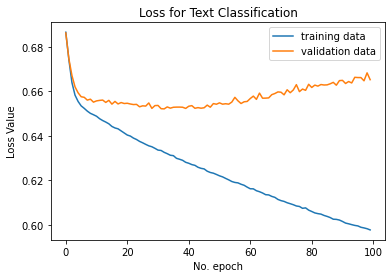

In [39]:
plt.plot(simple_history1.history['loss'], label='training data')
plt.plot(simple_history1.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

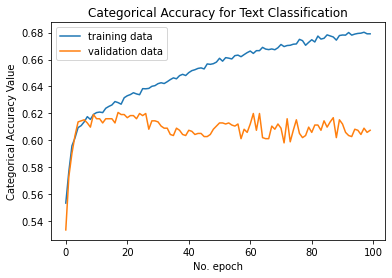

In [40]:
plt.plot(simple_history1.history['accuracy'], label='training data')
plt.plot(simple_history1.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [48]:
hub_model2 = Sequential()
hub_model2.add(hub_layer)
hub_model2.add(Dense(10, activation='relu'))
hub_model2.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
hub_model2.add(Dense(2, activation='sigmoid'))

hub_model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 2)                 22        
                                                                 
Total params: 124,644,110
Trainable params: 1,422
Non-trainable params: 124,642,688
_________________________________________________________________


In [49]:
hub_model2.compile(loss=loss,
              optimizer=optim, 
              metrics=metrics)

In [51]:
simple_history2 = hub_model2.fit(train_ds.shuffle(2000).batch(128), 
                                 epochs=100,
                                 validation_data=val_ds.batch(128),
                                 verbose=1)

Epoch 1/100
80/80 [==============================] - 1s 5ms/step - loss: 0.8302 - accuracy: 0.5620 - val_loss: 0.7073 - val_accuracy: 0.5553
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5928 - val_loss: 0.6725 - val_accuracy: 0.6005
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6044 - val_loss: 0.6662 - val_accuracy: 0.6020
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6079 - val_loss: 0.6643 - val_accuracy: 0.6090
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6087 - val_loss: 0.6621 - val_accuracy: 0.6121
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.6127 - val_loss: 0.6625 - val_accuracy: 0.6153
Epoch 7/100
80/80 [==============================] - 0s 5ms/step - loss: 0.6574 - accuracy: 0.6146 - val_loss: 0.6608 - val_accuracy: 0.6075
Epoch 8/100
8

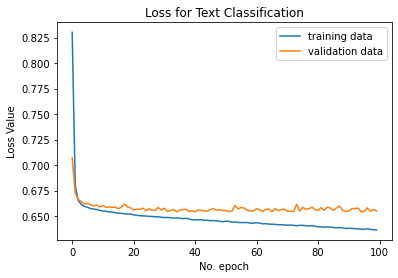

In [52]:
plt.plot(simple_history2.history['loss'], label='training data')
plt.plot(simple_history2.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

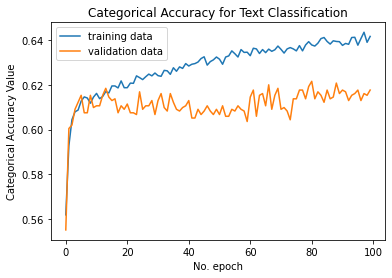

In [53]:
plt.plot(simple_history2.history['accuracy'], label='training data')
plt.plot(simple_history2.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [54]:
hub_model3 = Sequential()
hub_model3.add(hub_layer)
hub_model3.add(Dense(10, activation='relu'))
hub_model3.add(Dropout(0.1))
hub_model3.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
hub_model3.add(Dense(2, activation='sigmoid'))

hub_model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 2)                 22        
                                                                 
Total params: 124,644,110
Trainable params: 1,422
Non-trainable params: 124,642,688
_________________________________________________________________


In [55]:
hub_model3.compile(loss=loss,
              optimizer=optim, 
              metrics=metrics)

In [56]:
simple_history3 = hub_model3.fit(train_ds.shuffle(2000).batch(128), 
                                 epochs=100,
                                 validation_data=val_ds.batch(128),
                                 verbose=1)

Epoch 1/100
80/80 [==============================] - 1s 5ms/step - loss: 0.8414 - accuracy: 0.5607 - val_loss: 0.7082 - val_accuracy: 0.5724
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5924 - val_loss: 0.6753 - val_accuracy: 0.5966
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6027 - val_loss: 0.6672 - val_accuracy: 0.6090
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6104 - val_loss: 0.6669 - val_accuracy: 0.6067
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6613 - accuracy: 0.6051 - val_loss: 0.6658 - val_accuracy: 0.6044
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6099 - val_loss: 0.6629 - val_accuracy: 0.6153
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6095 - val_loss: 0.6620 - val_accuracy: 0.6121
Epoch 8/100
8

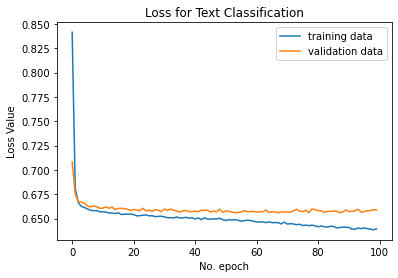

In [57]:
plt.plot(simple_history3.history['loss'], label='training data')
plt.plot(simple_history3.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

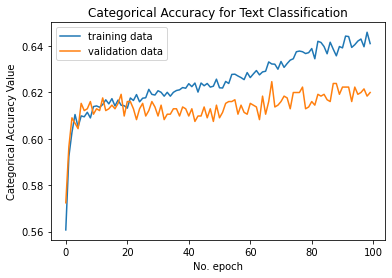

In [58]:
plt.plot(simple_history3.history['accuracy'], label='training data')
plt.plot(simple_history3.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

In [1]:
hub_model4 = Sequential()
hub_model4.add(hub_layer)
hub_model4.add(Dense(10, activation='relu'))
hub_model4.add(Dropout(0.1))
hub_model4.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
hub_model4.add(Dense(2, activation='sigmoid'))

hub_model4.summary()

In [60]:
hub_model4.compile(loss=loss,
              optimizer=optim, 
              metrics=metrics)

In [64]:
simple_history4 = hub_model4.fit(train_ds.shuffle(2000).batch(128), 
                                 epochs=500,
                                 validation_data=val_ds.batch(128),
                                 verbose=1)

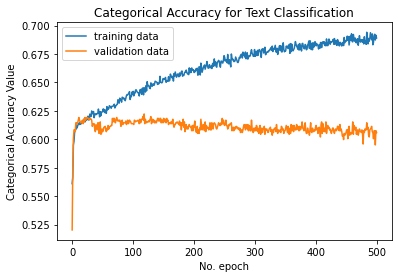

In [63]:
plt.plot(simple_history4.history['accuracy'], label='training data')
plt.plot(simple_history4.history['val_accuracy'], label='validation data')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Categorical Accuracy Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper left')
plt.show()

The validation accuracy of some embeded models have slightly outperformed the the categorical encoding models. There are still more different types of embeddings to try, so I'll stop here for now and continue with [Sentence Embedding](Sentence_Embedding.ipynb) in another notebook.